# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install cmake
!pip install xgboost

    100% |████████████████████████████████| 17.7MB 1.7MB/s eta 0:00:01  6% |██                              | 1.1MB 24.9MB/s eta 0:00:01    35% |███████████▌                    | 6.3MB 26.0MB/s eta 0:00:01    50% |████████████████▏               | 8.9MB 28.4MB/s eta 0:00:01    56% |██████████████████              | 10.0MB 27.4MB/s eta 0:00:01    63% |████████████████████▍           | 11.2MB 21.3MB/s eta 0:00:01    84% |███████████████████████████     | 14.9MB 25.4MB/s eta 0:00:01
    100% |████████████████████████████████| 788kB 4.2MB/s ta 0:00:011
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /root/.cache/pip/wheels/b3/92/d1/3236b795441c26eec7f7cdc2c5aae671789e725fb487d49d96
Successfully built xgboost


In [2]:
# import libraries here; add more as necessary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1. Loading data and exploration of the dataframes

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
level_att = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', )
del level_att['Unnamed: 0']

In [6]:
# some information about azdias dataframe

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.shape

(891221, 366)

In [7]:
azdias.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            891221 non-null int64
AGER_TYP                       891221 non-null int64
AKT_DAT_KL                     817722 non-null float64
ALTER_HH                       817722 non-null float64
ALTER_KIND1                    81058 non-null float64
ALTER_KIND2                    29499 non-null float64
ALTER_KIND3                    6170 non-null float64
ALTER_KIND4                    1205 non-null float64
ALTERSKATEGORIE_FEIN           628274 non-null float64
ANZ_HAUSHALTE_AKTIV            798073 non-null float64
ANZ_HH_TITEL                   794213 non-null float64
ANZ_KINDER                     817722 non-null float64
ANZ_PERSONEN                   817722 non-null float64
ANZ_STATISTISCHE_HAUSHALTE     798073 non-null float64
ANZ_TITEL                      817722 non-null float64
ARBEIT                         794005 non-null float64
BALLRAUM          

In [8]:
# some information about customer dataframe

In [9]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers.shape

(191652, 369)

In [11]:
customers.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
LNR                            191652 non-null int64
AGER_TYP                       191652 non-null int64
AKT_DAT_KL                     145056 non-null float64
ALTER_HH                       145056 non-null float64
ALTER_KIND1                    11766 non-null float64
ALTER_KIND2                    5100 non-null float64
ALTER_KIND3                    1275 non-null float64
ALTER_KIND4                    236 non-null float64
ALTERSKATEGORIE_FEIN           139810 non-null float64
ANZ_HAUSHALTE_AKTIV            141725 non-null float64
ANZ_HH_TITEL                   139542 non-null float64
ANZ_KINDER                     145056 non-null float64
ANZ_PERSONEN                   145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE     141725 non-null float64
ANZ_TITEL                      145056 non-null float64
ARBEIT                         141176 non-null float64
BALLRAUM            

In [6]:
# some information about value_att dataframe

In [8]:
level_att.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In value_att dataframe, we can find description and meaning of each attribute. We can use them in further steps.

### 0.2.The difference between columns of azdias and customers dataframes

In [12]:
# columns in customers not in azdias
diff_cust_azdias=np.setdiff1d(customers.columns, azdias.columns)

In [13]:
diff_cust_azdias

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

In [14]:
# columns in azdias not in customers
np.setdiff1d(azdias.columns, customers.columns)

array([], dtype=object)

### 0.3. Exploration of null values in azdias dataframe

In [69]:
azdias_nan_mean=azdias.isnull().mean()

In [70]:
azdias_nan_mean.sort_values(ascending=False)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


Text(0,0.5,'Proportion of missing value in column')

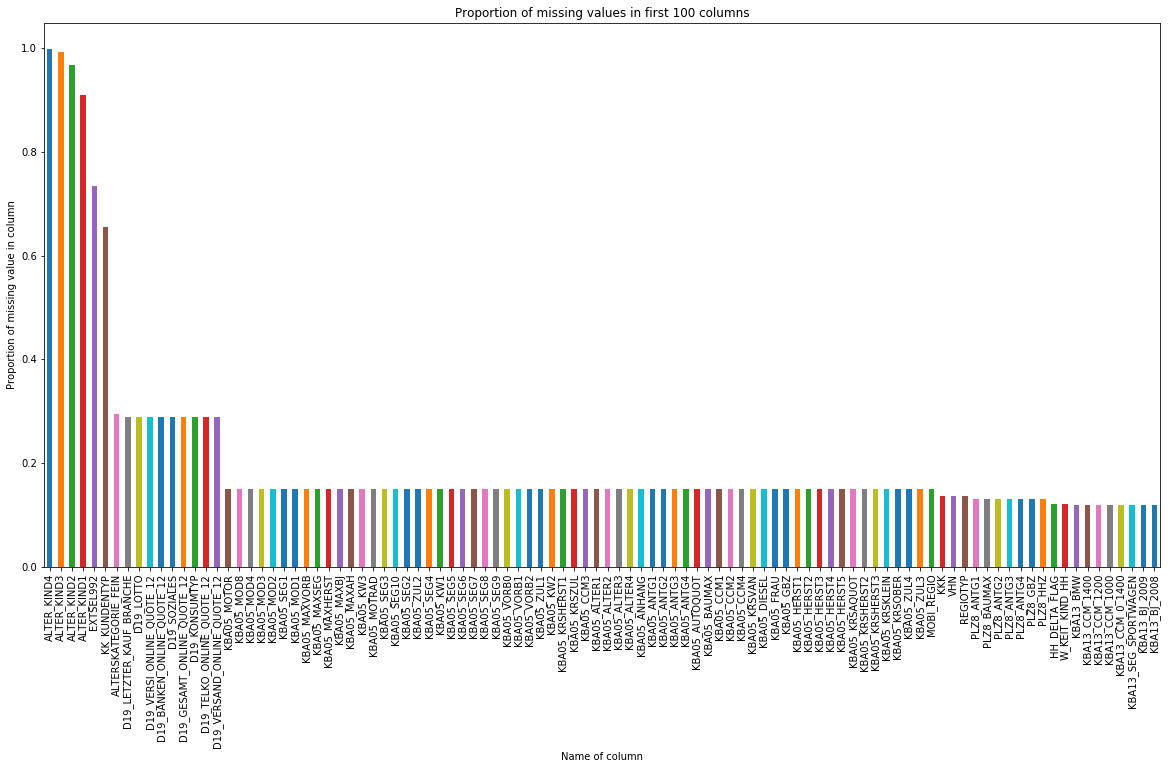

In [71]:
azdias_nan_mean.sort_values(ascending=False)[:100].plot(kind="bar", figsize=[20,10])

plt.title("Proportion of missing values in first 100 columns")
plt.xlabel("Name of column")
plt.ylabel("Proportion of missing value in column")

ALTER_KIND4, ALTER_KIND3, ALTER_KIND2, ALTER_KIND1, KK_KUNDENTYP, EXTSEL992 are the columns which includes highest amounts of NaN values. They have more than 60% missing values.

Text(0,0.5,'Number of columns')

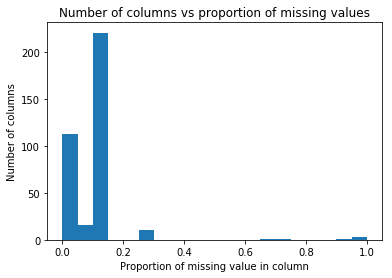

In [72]:
plt.hist(azdias_nan_mean, bins=20)

plt.title("Number of columns vs proportion of missing values")
plt.xlabel("Proportion of missing value in column")
plt.ylabel("Number of columns")

In the histogram, we can see that missing values in most of the columns less than 20%. There are few columns whose proportion of missing values more than 60%.

When we look at the rows:

In [73]:
azdias_row_nan_mean=azdias.isnull().mean(axis=1)

In [74]:
azdias_row_nan_mean.sort_values(ascending=False)

55664     0.707650
537799    0.707650
350182    0.707650
373501    0.707650
826869    0.707650
739769    0.704918
475330    0.704918
5099      0.704918
140317    0.704918
522174    0.704918
629707    0.704918
716386    0.704918
57866     0.704918
23667     0.704918
332962    0.704918
347712    0.704918
255742    0.704918
228624    0.699454
376576    0.691257
376536    0.691257
376578    0.691257
376534    0.691257
766507    0.691257
376523    0.691257
851362    0.691257
851358    0.691257
376506    0.691257
376499    0.691257
376490    0.691257
376586    0.691257
            ...   
145368    0.000000
711806    0.000000
85307     0.000000
89844     0.000000
19457     0.000000
677298    0.000000
594450    0.000000
730082    0.000000
48547     0.000000
33736     0.000000
555614    0.000000
837125    0.000000
54129     0.000000
436519    0.000000
415359    0.000000
856386    0.000000
377279    0.000000
193782    0.000000
664563    0.000000
617078    0.000000
642237    0.000000
346347    0.

Text(0,0.5,'Number of rows')

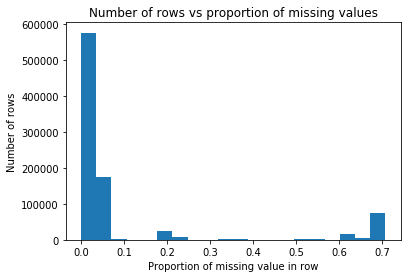

In [75]:
plt.hist(azdias_row_nan_mean, bins=20)

plt.title("Number of rows vs proportion of missing values")
plt.xlabel("Proportion of missing value in row")
plt.ylabel("Number of rows")

According to the histogram, around 800,000 rows have missing values less than 10% of them. There are around 100,000 rows whose missing value percent is more than 60%.

#### Remove missing values

In [76]:
# We need to find out which columns and rows to drop

In [77]:
# columns

In [78]:
azdias_nan_mean[azdias_nan_mean>0.3]

ALTER_KIND1     0.909048
ALTER_KIND2     0.966900
ALTER_KIND3     0.993077
ALTER_KIND4     0.998648
EXTSEL992       0.733996
KK_KUNDENTYP    0.655967
dtype: float64

In [79]:
columns_to_drop=azdias_nan_mean[azdias_nan_mean>0.3].index

In [80]:
columns_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')

In [81]:
# getting copy azdias
azdias_clean=azdias.copy()

In [82]:
# dropping columns to drop
azdias_clean.drop(columns=columns_to_drop, inplace=True)

In [83]:
# rows

In [84]:
azdias_row_nan_mean[azdias_row_nan_mean>0.5]

0         0.688525
11        0.691257
14        0.691257
17        0.691257
24        0.691257
26        0.543716
30        0.644809
35        0.688525
46        0.644809
48        0.691257
53        0.688525
54        0.691257
61        0.688525
62        0.688525
69        0.691257
75        0.691257
76        0.688525
81        0.688525
83        0.688525
90        0.644809
97        0.691257
99        0.691257
103       0.691257
106       0.688525
108       0.691257
109       0.688525
112       0.691257
133       0.691257
137       0.691257
138       0.603825
            ...   
891021    0.688525
891027    0.688525
891044    0.691257
891049    0.691257
891055    0.620219
891061    0.688525
891062    0.546448
891063    0.688525
891064    0.691257
891069    0.554645
891072    0.691257
891074    0.644809
891092    0.691257
891095    0.691257
891100    0.614754
891117    0.546448
891119    0.568306
891120    0.535519
891130    0.612022
891137    0.617486
891140    0.617486
891159    0.

In [85]:
len(azdias_row_nan_mean[azdias_row_nan_mean>0.5])

99231

In [86]:
rows_to_drop=azdias_row_nan_mean[azdias_row_nan_mean>0.5].index

In [87]:
rows_to_drop

Int64Index([     0,     11,     14,     17,     24,     26,     30,     35,
                46,     48,
            ...
            891140, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=99231)

In [88]:
# dropping rows
azdias_clean.drop(rows_to_drop, inplace=True)

In [89]:
print("shape before cleaning: ", azdias.shape)
print("shape after cleaning: ", azdias_clean.shape)

shape before cleaning:  (891221, 366)
shape after cleaning:  (791990, 360)


### 0.4. Remove the categorical columns which involve too many variables

If a categorical column has too many variables it might be a problem when we convert it to dummy variables. It will increase the number of columns that are already too many. So, I decided to drop some of them if we have this kind of column.

In [90]:
# checking feature counts and types of the columns
too_many_feat=[]
for col in azdias_clean.columns:
    if azdias_clean[col].nunique()>25:
        too_many_feat.append((col, azdias_clean[col].nunique(), azdias_clean[col].dtypes))

In [91]:
too_many_feat

[('LNR', 791990, dtype('int64')),
 ('ALTERSKATEGORIE_FEIN', 26, dtype('float64')),
 ('ANZ_HAUSHALTE_AKTIV', 292, dtype('float64')),
 ('ANZ_PERSONEN', 29, dtype('float64')),
 ('ANZ_STATISTISCHE_HAUSHALTE', 268, dtype('float64')),
 ('CAMEO_DEU_2015', 45, dtype('O')),
 ('CAMEO_INTL_2015', 43, dtype('O')),
 ('D19_LETZTER_KAUF_BRANCHE', 35, dtype('O')),
 ('EINGEFUEGT_AM', 4474, dtype('O')),
 ('EINGEZOGENAM_HH_JAHR', 37, dtype('float64')),
 ('GEBURTSJAHR', 117, dtype('int64')),
 ('KBA13_ANZAHL_PKW', 1261, dtype('float64')),
 ('LP_LEBENSPHASE_FEIN', 41, dtype('float64')),
 ('MIN_GEBAEUDEJAHR', 29, dtype('float64')),
 ('VERDICHTUNGSRAUM', 46, dtype('float64'))]

Some of these columns look problematic.
1. LNR column has so many unique value bu it is ID column. So, we will keep it.
2. CAMEO_DEU_2015, CAMEO_INTL_2015, D19_LETZTER_KAUF_BRANCHE and are categorical columns which have too many features.
3. EINGEFUEGT_AM column seems to a categorical column and it should be in datetime type.

In [92]:
# change dtype of EINGEFUEGT_AM column from object to datetime
azdias_clean["EINGEFUEGT_AM"]=pd.to_datetime(azdias_clean["EINGEFUEGT_AM"])

In [93]:
# extract only year
azdias_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(azdias_clean["EINGEFUEGT_AM"]).year

In [94]:
azdias_clean["EINGEFUEGT_AM"].head()

1    1992
2    1992
3    1997
4    1992
5    1992
Name: EINGEFUEGT_AM, dtype: int64

In [95]:
# dropping columns that have too many features and id column
azdias_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)

In [96]:
azdias_clean.shape

(791990, 357)

### 0.5. Convert remaining categorical columns to encoded and dummy variables

In [43]:
# Finding categorical columns

In [97]:
categorical_cols=[]
for col in azdias_clean.columns:
    if azdias_clean[col].dtypes=="object":
        categorical_cols.append((col, azdias_clean[col].nunique()))
categorical_cols

[('CAMEO_DEUG_2015', 19), ('OST_WEST_KZ', 2)]

In [98]:
# CAMEO_DEUG_2015 column has too many features so converting encoded instead dummies seems better
azdias_clean["CAMEO_DEUG_2015"]=pd.factorize(azdias_clean["CAMEO_DEUG_2015"])[0]

In [99]:
# getting dummy column for OST_WEST_KZ
azdias_clean=pd.get_dummies(azdias_clean, drop_first=True)

In [100]:
azdias_clean.shape

(791990, 357)

### 0.6. Complete missing values

In this step, we impute the missing values by using mode values for each column.

In [101]:
print("number of missing values in azdias before imputing: ", azdias_clean.isnull().sum().sum())

number of missing values in azdias before imputing:  4952737


In [102]:
# impute Nan values by using sklern impute function by using mode strategy

imputer = Imputer(strategy='most_frequent')

In [103]:
# fit and transform of imputer on dataframe

azdias_clean=pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)

In [104]:
print("number of missing values in azdias after imputing: ", azdias_clean.isnull().sum().sum())

number of missing values in azdias after imputing:  0


### 0.7. Identify and remove correlated features

If we have highly correlated features, we think about getting rid of them. They might cause overfitting and also we have still too many features.

In [105]:
# getting absolute value correlation matrix by using corr from pandas
corr_fet = azdias_clean.corr().abs()

In [106]:
corr_fet.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,1.000000,0.019696,0.005084,0.011712,0.004099,0.051198,0.009621,0.022324,0.025062,0.054921,...,0.021967,0.066103,0.103859,0.019138,0.002809,0.059260,0.038243,0.004174,0.000164,0.707126
AGER_TYP,0.019696,1.000000,0.281603,0.002101,0.405207,0.025516,0.001925,0.132502,0.014562,0.020573,...,0.051294,0.189732,0.289147,0.239132,0.143615,0.012730,0.154369,0.014680,0.340526,0.021134
AKT_DAT_KL,0.005084,0.281603,1.000000,0.177541,0.298895,0.119516,0.028476,0.077344,0.142287,0.120605,...,0.374296,0.410785,0.384257,0.000127,0.043381,0.036304,0.179195,0.040862,0.196882,0.009064
ALTER_HH,0.011712,0.002101,0.177541,1.000000,0.301095,0.076373,0.042730,0.180002,0.331046,0.082307,...,0.395162,0.316018,0.196415,0.275779,0.050558,0.026028,0.089730,0.016196,0.158987,0.020931
ALTERSKATEGORIE_FEIN,0.004099,0.405207,0.298895,0.301095,1.000000,0.016916,0.022308,0.182173,0.042611,0.008105,...,0.139947,0.020063,0.157347,0.316126,0.220822,0.008741,0.161351,0.018834,0.437378,0.001677


In [107]:
# upper triangle of correlation matrix
upper = corr_fet.where(np.triu(np.ones(corr_fet.shape), k=1).astype(np.bool))
upper.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,NaN,0.019696,0.005084,0.011712,0.004099,0.051198,0.009621,0.022324,0.025062,0.054921,...,0.021967,0.066103,0.103859,0.019138,0.002809,0.059260,0.038243,0.004174,0.000164,0.707126
AGER_TYP,NaN,NaN,0.281603,0.002101,0.405207,0.025516,0.001925,0.132502,0.014562,0.020573,...,0.051294,0.189732,0.289147,0.239132,0.143615,0.012730,0.154369,0.014680,0.340526,0.021134
AKT_DAT_KL,NaN,NaN,NaN,0.177541,0.298895,0.119516,0.028476,0.077344,0.142287,0.120605,...,0.374296,0.410785,0.384257,0.000127,0.043381,0.036304,0.179195,0.040862,0.196882,0.009064
ALTER_HH,NaN,NaN,NaN,NaN,0.301095,0.076373,0.042730,0.180002,0.331046,0.082307,...,0.395162,0.316018,0.196415,0.275779,0.050558,0.026028,0.089730,0.016196,0.158987,0.020931
ALTERSKATEGORIE_FEIN,NaN,NaN,NaN,NaN,NaN,0.016916,0.022308,0.182173,0.042611,0.008105,...,0.139947,0.020063,0.157347,0.316126,0.220822,0.008741,0.161351,0.018834,0.437378,0.001677


In [113]:
threshold=0.85

In [114]:
# Selecting columns whose correlation above the threshold
cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

cols_to_drop

['ANZ_STATISTISCHE_HAUSHALTE',
 'CJT_TYP_2',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP_MAX',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA05_KRSAQUOT',
 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2',
 'KBA05_KRSHERST3',
 'KBA05_SEG2',
 'KBA05_SEG5',
 'KBA05_SEG6',
 'KBA05_SEG9',
 'KBA05_ZUL4',
 'KBA13_HALTER_40',
 'KBA13_HALTER_55',
 'KBA13_HALTER_66',
 'KBA13_HERST_SONST',
 'KBA13_KMH_250',
 'KBA13_SITZE_5',
 'KBA13_VW',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_GROB',
 'MIN_GEBAEUDEJAHR',
 'ORTSGR_KLS9',
 'PLZ8_ANTG1',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'VK_DISTANZ',
 'VK_ZG11',
 'ANREDE_KZ']

In [115]:
len(cols_to_drop)

45

In [119]:
# dropping most correlated columns (>0.85)
azdias_clean.drop(columns=cols_to_drop, inplace=True)

In [120]:
azdias_clean.shape

(791990, 312)

### 0.8. Remove outliers

I use sciPy stats.zscore() function to detect outliers in the dataset. It returns the z-score which standardized by mean and standard deviation of the input. I keep the values that z-score<6 for all values in a row and that drops more than 100,000 rows in this step.

In [121]:
# calculate z score for each value in dataset
z = np.abs(stats.zscore(azdias_clean))

In [122]:
# filter all rows whose z score less than 6
azdias_clean = azdias_clean[(z < 6).all(axis=1)]

In [123]:
# reset index for new dataframe
azdias_clean.reset_index(drop=True, inplace=True)

In [124]:
azdias_clean.shape

(688713, 312)

### 0.9. Scale the dataset

Our next step is dimensionality reduction by using PCA and normalization is important for it because PCA is about maximizing variance. 
In this step, sklearn StandardScaler() is used for the normalization of the dataset.

In [125]:
# define scaler by using StandardScaler from sklearn, which standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

In [126]:
# to keep LNR column same we need to copy it
lnr=azdias_clean['LNR']

In [127]:
# fit and transform of scaler on dataframe
azdias_clean=pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns)

In [128]:
# get back LNR column again
azdias_clean['LNR']=lnr

# set index LNR column
azdias_clean.set_index("LNR", inplace=True)

In [129]:
azdias_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
910225.0,-0.572573,1.222088,0.835070,0.684332,0.242362,-0.147496,-0.295067,-0.611189,0.0,-0.178999,...,-0.557781,-0.375764,-0.357962,0.996437,-0.626223,0.551127,-1.067185,1.130249,0.162732,0.50669
910226.0,1.851919,-0.959254,0.309388,-0.202169,-0.628346,-0.147496,-0.295067,-1.523856,0.0,-1.183259,...,-0.557781,0.517486,-2.098319,0.284947,0.967550,0.551127,1.554442,-0.294103,1.088797,0.50669
910244.0,2.660083,-0.959254,-0.084874,-0.867045,-0.241365,-0.147496,-0.295067,-0.611189,0.0,-1.183259,...,0.825610,-0.375764,-0.357962,1.352182,0.967550,0.551127,1.554442,0.418073,-1.689396,0.50669
910248.0,-0.572573,1.222088,-1.399080,0.241081,-0.338110,-0.147496,-0.295067,-0.611189,0.0,0.825261,...,-0.557781,-0.375764,-0.357962,0.284947,-0.626223,0.551127,0.505791,0.418073,-0.763332,0.50669
910261.0,-0.572573,-0.959254,0.440808,0.019456,-0.144619,-0.147496,-0.295067,-0.611189,0.0,-1.183259,...,-0.557781,-0.375764,-0.357962,1.352182,0.436293,0.551127,-1.591510,-1.718455,-1.689396,0.50669


### 0.10. Create ETL pipline

We create ETL pipline that includes all the steps above. These steps are removing most of the null values, converting categegorical columns to encoded, removing outliers then scaling the dataset.

In [66]:
def data_preprocessing (df, df_name = None):
    """
    Perform cleaning of demographics dataset by dropping missing columns and rows, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
    # Drop columns from customer dataset, which are not found in azdias dataset 
    if df_name=='customers':
        df_clean.drop(columns= ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Find the rows that include too many missing values and drop them if ratio of missing values more than 0.5
    df_row_nan_mean=df_clean.isnull().mean(axis=1)
    rows_to_drop=df_row_nan_mean[df_row_nan_mean>0.5].index
    df_clean.drop(rows_to_drop, inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = Imputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    
    # Remove outliers from dataset by using z score
    z = np.abs(stats.zscore(df_clean))
    df_clean = df_clean[(z < 6).all(axis=1)]
    df_clean.reset_index(drop=True, inplace=True)

    # Standardization of dataset
    lnr=df_clean['LNR']
    scaler = StandardScaler()
    df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
    df_clean['LNR']=lnr
   
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean


Lets apply the function to customer dataset

In [67]:
customer_clean = data_preprocessing (customers, df_name = "customers")

In [68]:
customer_clean.shape

(121955, 311)

In [131]:
customer_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
9626.0,0.915373,-0.370541,-0.190000,-0.059776,-0.412169,-0.136245,-0.270606,-0.152386,0.0,-1.818756,...,-0.819812,-0.654783,0.510790,0.187028,0.848655,0.28177,1.582809,0.449888,0.691006,0.288339
143872.0,-1.356372,-0.370541,-0.835552,-2.540954,-0.412169,-0.136245,-0.270606,-0.893326,0.0,0.170530,...,0.942325,-0.654783,1.392021,1.887010,0.848655,0.28177,-0.830905,0.449888,0.691006,0.288339
143873.0,0.158125,-0.370541,-0.512776,-0.556011,-0.541721,-0.136245,-0.270606,-1.634266,0.0,-1.818756,...,-0.819812,-0.654783,-0.370442,0.527024,0.848655,0.28177,1.582809,-1.089565,0.691006,0.288339
143874.0,-1.356372,-0.370541,1.423880,0.932696,0.365142,-0.136245,-0.270606,1.329494,0.0,0.170530,...,0.942325,-0.654783,1.392021,-0.492965,-1.283352,0.28177,-0.348162,-1.089565,-0.714950,0.288339
143888.0,0.158125,-0.370541,-0.028612,-0.059776,-0.412169,-0.136245,-0.270606,-0.152386,0.0,0.170530,...,0.942325,3.160434,1.392021,-1.172957,0.848655,0.28177,-1.313648,-0.319838,-0.714950,0.288339


customer_clean and azdias clean dataframes have same columns.

In [9]:
azdias_clean = data_preprocessing (azdias, df_name = "azdias")

In [10]:
azdias_clean.shape

(688741, 311)

In [57]:
azdias_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
NaN,-0.572580,1.222098,0.835052,0.684323,0.242382,-0.147493,-0.295068,-0.611188,0.0,-0.178981,...,-0.557780,-0.375764,-0.357962,0.996448,-0.626228,0.551158,-1.067186,1.130244,0.162719,0.506686
910225.0,1.851903,-0.959256,0.309366,-0.202173,-0.628336,-0.147493,-0.295068,-1.523867,0.0,-1.183232,...,-0.557780,0.517492,-2.098315,0.284958,0.967544,0.551158,1.554406,-0.294099,1.088764,0.506686
910226.0,2.660064,-0.959256,-0.084899,-0.867044,-0.241350,-0.147493,-0.295068,-0.611188,0.0,-1.183232,...,0.825615,-0.375764,-0.357962,1.352193,0.967544,0.551158,1.554406,0.418073,-1.689372,0.506686
NaN,-0.572580,1.222098,-1.399114,0.241075,-0.338097,-0.147493,-0.295068,-0.611188,0.0,0.825269,...,-0.557780,-0.375764,-0.357962,0.284958,-0.626228,0.551158,0.505769,0.418073,-0.763327,0.506686
910244.0,-0.572580,-0.959256,0.440787,0.019451,-0.144604,-0.147493,-0.295068,-0.611188,0.0,-1.183232,...,-0.557780,-0.375764,-0.357962,1.352193,0.436287,0.551158,-1.591505,-1.718442,-1.689372,0.506686


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1. Reduction of dimensionality 

Use Principal component analysis from (PCA) from sklearn.

In [15]:
pca = PCA().fit(azdias_clean)

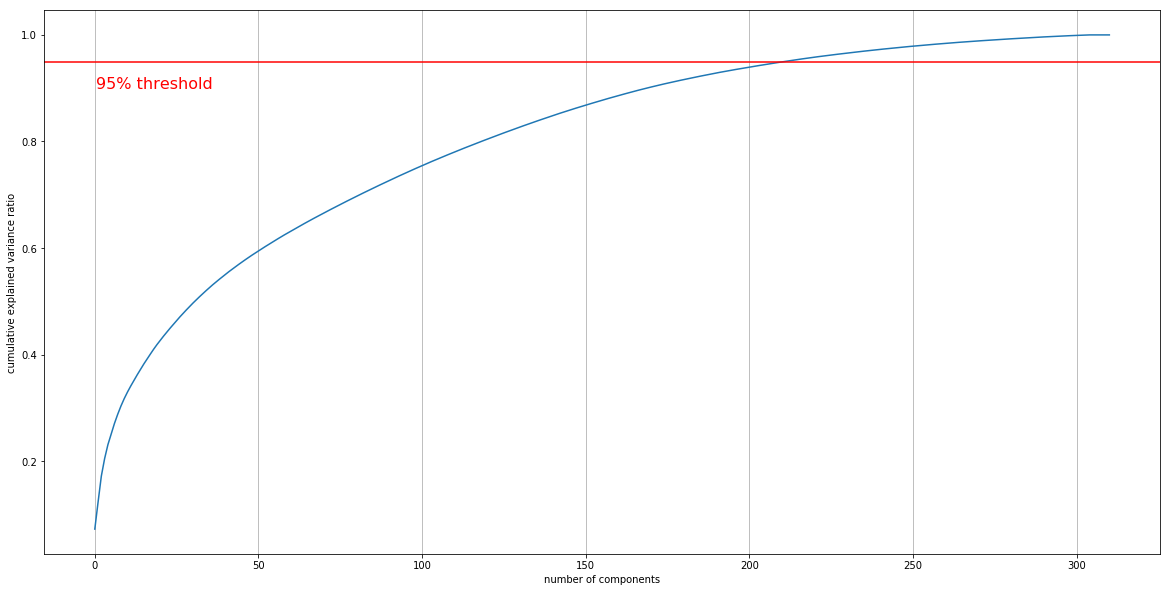

In [16]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')

plt.axhline(y=0.95, color='r')
plt.text(0.5, 0.9, '95% threshold', color = 'red', fontsize=16)

plt.grid(axis='x')


According the graph above, number of component for 95% threshold is around 215.

#### 1.1.1. Dimension reduction function

In [11]:
def pca_reduction(df, n_components):
    """
    Perform PCA dimension reduction to dataset
    
    Input: 
    df: Demographic dataset (DataFrame)
    n_components: Number of components for PCA
    
    Output:
    df_reduced: PCA applied dataset (DataFrame)
    pca: PCA object
    """
    # PCA
    pca = PCA(n_components=n_components)
    # fit and transform of PCA
    df_reduced = pd.DataFrame(pca.fit_transform(df), columns=["PC"+str(i) for i in range(n_components)])
    
    return df_reduced, pca

In [12]:
azdias_reduced, azdias_pca = pca_reduction(azdias_clean, 215)

In [13]:
azdias_reduced.shape

(688741, 215)

In [14]:
customer_reduced, customer_pca = pca_reduction(customer_clean, 215)

In [15]:
customer_reduced.shape

(121955, 215)

#### 1.1.2. PCA plot function

In [16]:
def pca_plot(pca, threshold=0.95):

    """
    Perform cumulative sum of PCA explained_variance_ratio_ then plot
    cumulative explained variance ratio vs number of components
    
    Input: 
    pca: PCA object
    threshold: threshold for cumulative explained variance ratio (int, default=0.95)
    
    Output:
    return None
    """
    
    plt.figure(figsize=(16,8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance ratio')

    plt.axhline(y=threshold, color='r')
    plt.text(0.5, threshold-0.05, str(threshold*100)+'% threshold', color = 'red', fontsize=16)

    plt.grid(axis='x')

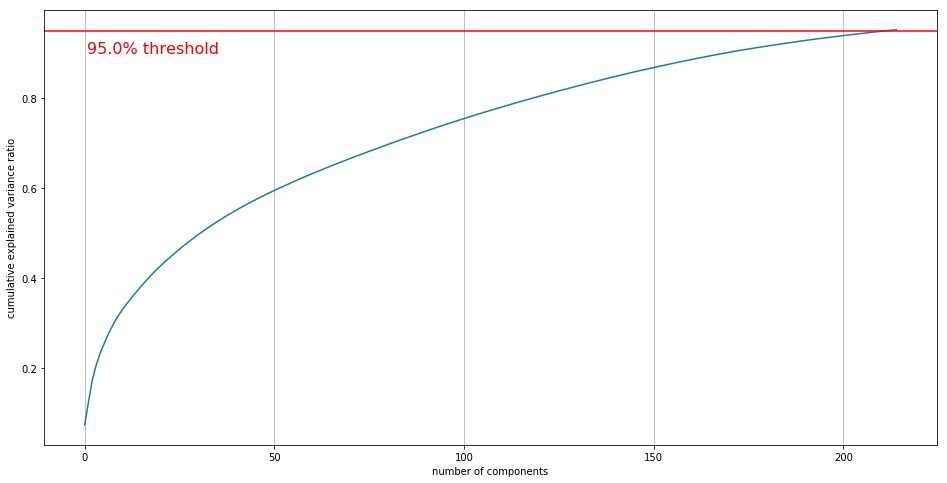

In [17]:
pca_plot(azdias_pca)

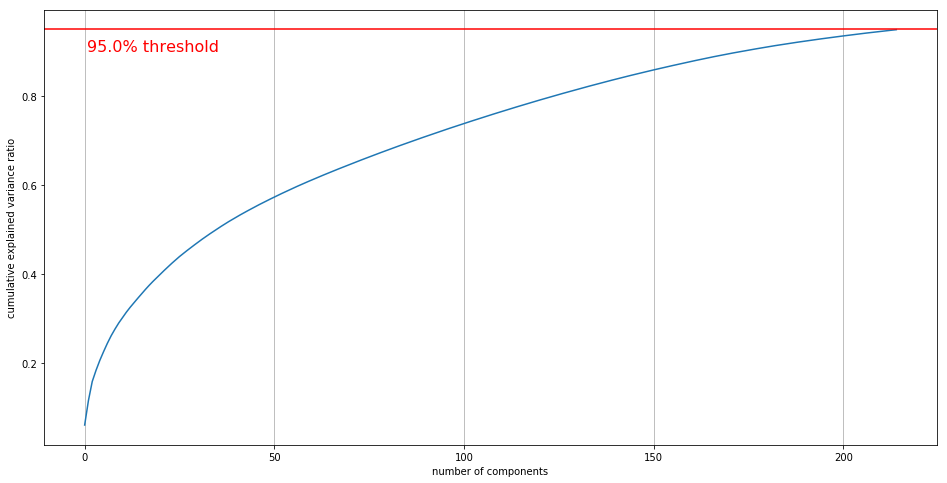

In [18]:
pca_plot(customer_pca)

By using the plots above, we can see that our dimensions are enough for the threshold which 95%.

#### 1.1.3. PCA feature importance

PCA is also important to determine the feature importance. I prepared functions. One of them creates a matrix which shows feature weights for each principal components. 
<br>In the final dataframe, principal components are sorted according to importance. So, PC 0 is the most important one.

In [26]:
def pca_feature_importance(pca, df):

    """
    Create a matrix which involves feature weights for every principal components
    
    Input: 
    pca: PCA object for df
    df: Demographic dataset (DataFrame)
    
    Output:
    fet_import_matrix: feature importance for each principal component matrix (DataFrame)
    
    """
    # number of components
    n_comp= pca.n_components_
    
    # index column of dataframe
    idx=["PC"+str(i) for i in range(n_comp)]
    
    # create dataframe
    fet_import_matrix=pd.DataFrame((pca.components_), columns=df.columns, index=idx)
    
    return fet_import_matrix

In [27]:
azdias_pca_feature_importance = pca_feature_importance(azdias_pca, azdias_clean)

In [28]:
azdias_pca_feature_importance.shape

(215, 311)

In [29]:
azdias_pca_feature_importance.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
PC0,0.042823,-0.072772,0.027583,-0.040640,-0.108187,-0.021802,0.023589,0.072847,-2.646978e-23,-0.108179,...,0.004563,0.048427,-0.037194,-0.080613,-0.033730,0.032988,0.046203,-0.096628,0.051987,0.057270
PC1,-0.027390,0.029917,-0.007878,0.022467,0.031184,0.026655,-0.002052,-0.021882,2.710505e-20,-0.032407,...,-0.001117,-0.030673,0.044826,0.023989,0.005340,-0.021003,-0.084542,0.009952,-0.032816,0.108505
PC2,-0.130382,0.031102,0.101887,0.165785,-0.022632,-0.011388,0.079798,0.062512,0.000000e+00,-0.032339,...,-0.002931,0.003530,-0.023759,-0.098751,-0.118191,-0.064426,0.033618,0.041679,-0.181126,0.013248
PC3,0.069525,-0.118861,0.090880,-0.014189,0.036146,0.017183,0.046273,0.121131,8.673617e-19,0.091098,...,0.031745,0.092245,0.018726,-0.177369,-0.047469,0.001218,-0.082396,-0.044307,0.036686,-0.066458
PC4,-0.027918,0.035545,-0.014693,0.024659,0.011580,0.009584,-0.008832,-0.034159,1.387779e-17,0.076806,...,0.001455,-0.016778,-0.033662,0.025275,0.003468,-0.012622,-0.023086,0.019593,-0.038462,-0.163040


Second function creates a dataframe involves top feature weights with feature description for spesific principal component.

In [36]:
def most_important_features(pca_feature_importance_matrix, df, df_attribute, component_number):
    """
    Create a dataframe involves top feature weights with feature description for spesific principal component
    
    Input: 
    pca_feature_importance_matrix: pca_feature_importance_matrix: PCA feature importance for 
                                    each principal component matrix (DataFrame)
    df: Demographic dataset (DataFrame)
    df_attribute: Dataset which includes descriptions and meanings of features
    component_number: number of the component (int)
    
    Output:
    pc_tops: top 3 positive and negative features with description and meaning for principal component given
    
    """
    # select top 3 and bottom 3 features from pca_feature_importance_matrix
    pc_tops=pd.DataFrame(pca_feature_importance_matrix.iloc[component_number].sort_values(ascending=False).iloc[[0,1,2,-3,-2,-1]])
    
    # merge pc_tops with attributes dataset
    pc_tops = pd.merge(left=pc_tops, right=df_attribute, how='left', left_on=pc_tops.index, right_on='Attribute')
    
    # set index attribute column
    pc_tops=pc_tops.set_index("Attribute").drop(columns=["Information level"])
    
    return pc_tops

In [37]:
most_important_features(azdias_pca_feature_importance, azdias_clean, level_att, 0)

,PC0,Description,Additional notes
Attribute,,,
KBA13_ANTG1,0.152924,NaN,NaN
MOBI_REGIO,0.152100,moving patterns,NaN
LP_STATUS_FEIN,0.149898,social status fine,NaN
KBA13_BAUMAX,-0.145598,NaN,NaN
HH_EINKOMMEN_SCORE,-0.148534,estimated household_net_income,modelled on different AZ DIAS data
KBA13_ANTG3,-0.151954,NaN,NaN


In [38]:
most_important_features(azdias_pca_feature_importance, azdias_clean, level_att, 1)

,PC1,Description,Additional notes
Attribute,,,
KBA13_HERST_BMW_BENZ,0.197164,share of BMW & Mercedes Benz within the PLZ8,NaN
KBA13_SEG_OBEREMITTELKLASSE,0.169697,share of upper middle class cars and upper cla...,NaN
KBA13_MERCEDES,0.167052,share of MERCEDES within the PLZ8,NaN
KBA13_KMH_180,-0.129983,share of cars with max speed between 110 km/h ...,NaN
KBA13_KMH_140_210,-0.140899,share of cars with max speed between 140 and 2...,NaN
KBA13_SEG_KLEINWAGEN,-0.141554,share of small and very small cars (Ford Fiest...,NaN


In [39]:
most_important_features(azdias_pca_feature_importance, azdias_clean, level_att, 2)

,PC2,Description,Additional notes
Attribute,,,
PRAEGENDE_JUGENDJAHRE,0.211845,dominating movement in the person's youth (ava...,own typology modelled on different AZ DIAS data
CJT_TYP_1,0.198174,NaN,NaN
FINANZ_SPARER,0.194463,financial typology: money saver,NaN
CJT_TYP_5,-0.181669,NaN,NaN
CJT_TYP_4,-0.184357,NaN,NaN
FINANZ_VORSORGER,-0.189756,financial typology: be prepared,NaN


When we look at the tables above, we can interpret them. We can see most correlated and most uncorrelated features for each principal components. 
<br>For example, PC1 has positive correlation with luxury cars and negative correlation with regular cars.

### 1.2. Clustering

#### 1.2.1. Elbow method

Elbow method is one most known method to find number of clusters in the unsupervised learning. To determine ideal number of clusters, we need to select k at the point that slope of the curve has sharp decrease. That is called "elbow".

In [39]:
# try different cluster numbers by using for loop
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(azdias_reduced)
    Sum_of_squared_distances.append(km.inertia_)

Text(0.5,1,'Elbow Method For Optimal k')

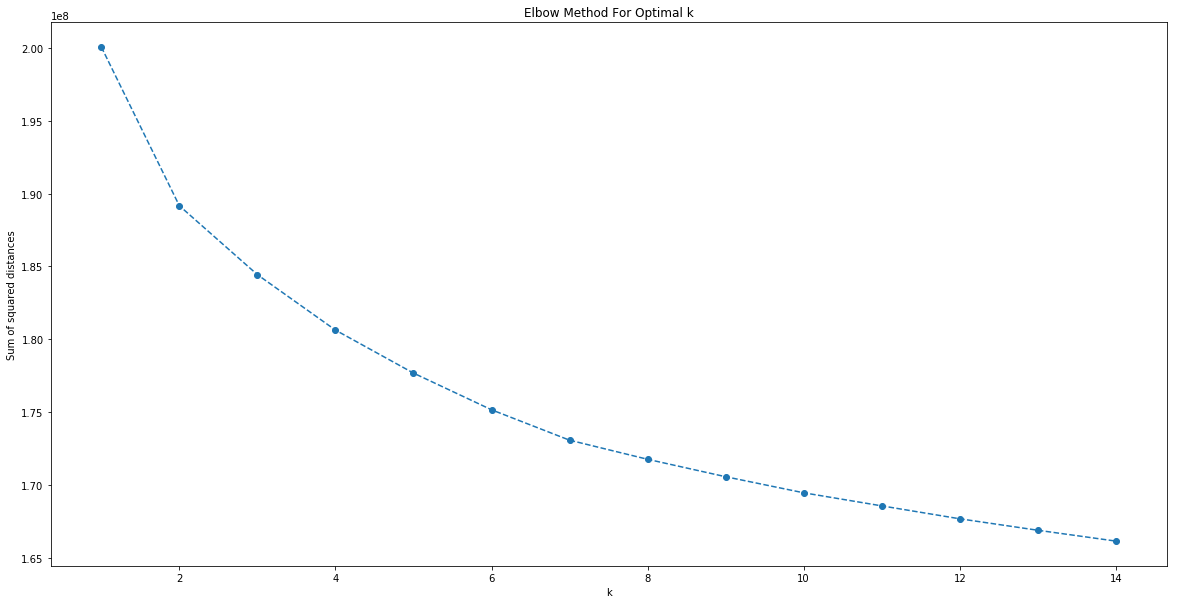

In [43]:
# plot to see elbow
plt.figure(figsize=(20,10))
plt.plot(K, Sum_of_squared_distances, 'o--')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

There is an elbow at k=2. There is also a small elbow at k=7. 2 clusters may be too small so I prefer to use 7 clusters instead of 2.

#### 1.2.2. Clustering for k=7

In [40]:
# kmeans for clustering with n_clusters=7 and fit the model
km = KMeans(n_clusters=7)
km.fit(azdias_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [41]:
# predict azdias dataset
azdias_predicted = km.predict(azdias_reduced)

In [42]:
azdias_predicted.shape

(688741,)

In [43]:
# create dataframe for azdias_predicted
azdias_clustered=pd.DataFrame(azdias_predicted, columns=["cluster"])

In [44]:
# predict customer dataset
customer_predicted = km.predict(customer_reduced)

In [45]:
customer_predicted.shape

(121955,)

In [46]:
# create dataframe for customer_predicted
customer_clustered=pd.DataFrame(customer_predicted, columns=["cluster"])

In [260]:
# create dataframe of proportion of clusters for both dataset
clusters=pd.DataFrame(data={'azdias_clusters': (azdias_clustered["cluster"].value_counts().sort_index().values/azdias_clustered.shape[0]), 
 'customer_clusters': (customer_clustered["cluster"].value_counts().sort_index().values/customer_clustered.shape[0])}, index=range(1,8))

In [261]:
clusters

,azdias_clusters,customer_clusters
1,0.106340,0.117035
2,0.107743,0.120052
3,0.157370,0.246427
4,0.144798,0.142897
5,0.181765,0.167021
6,0.132963,0.085179
7,0.169021,0.121389


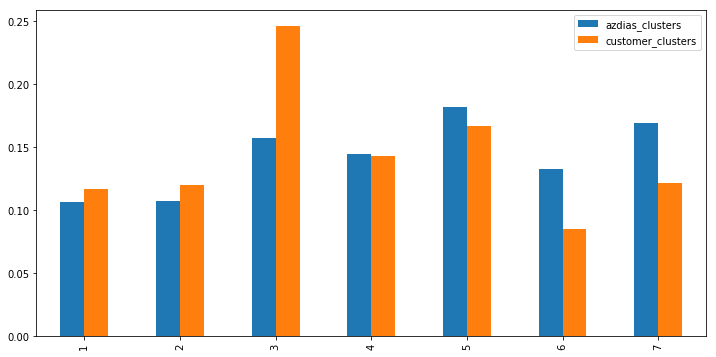

In [262]:
clusters.plot(kind="bar", figsize=[12,6])

***When we look at graph above, cluster 6 and cluster 7 are overrepresented. Cluster 3 is underrepresented.***

#### 1.2.2. Avarerage feature values for each cluster

In [175]:
# create a dataframe by using inverse transform
cluster_clean=pd.DataFrame(azdias_pca.inverse_transform(km.cluster_centers_), 
                           columns=azdias_clean.columns)

In [176]:
cluster_clean

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
0,0.088634,-0.029458,-0.127369,-0.143032,-0.033772,0.209600,-0.086480,-0.098485,1.231623e-16,-0.071590,...,0.069581,-0.081593,0.281869,0.056644,0.092738,-0.028772,-0.639443,-0.158130,0.170236,0.334425
1,0.110439,-0.005704,-0.095944,-0.073896,0.148858,-0.001465,-0.119236,-0.144869,8.970092e-16,0.871150,...,0.061160,0.061843,-0.185833,0.041254,0.107379,0.025405,0.218555,0.189580,0.129318,-1.881643
2,0.426376,0.053081,-0.419169,-0.490337,0.452323,0.058096,-0.262490,-0.307940,-5.773759e-16,0.373573,...,-0.004730,-0.101791,0.232844,0.532929,0.408329,0.169896,-0.294537,0.052802,0.599375,0.238124
3,-0.507568,0.395936,0.137259,0.550373,0.776304,0.147507,0.003810,-0.256154,-1.496136e-16,0.545220,...,-0.044987,-0.256961,0.289580,0.181925,0.043104,-0.353763,-0.215901,0.667943,-0.700945,-0.095171
4,0.556009,-0.380667,-0.248875,-0.678224,-0.507508,-0.120008,-0.213455,-0.042740,-2.969906e-17,-0.570028,...,0.022681,0.075069,-0.189208,0.103291,0.355057,0.269720,0.358171,-0.485012,0.668494,0.319159
5,-0.165756,-0.522432,0.696049,0.296923,-0.497965,-0.122165,0.650531,1.123153,4.317808e-16,-0.428272,...,0.048948,0.602226,-0.239003,-1.226780,-0.920928,0.193606,0.230195,-0.612803,-0.118632,0.195866
6,-0.555874,0.453909,0.134072,0.617935,-0.222248,-0.086207,0.089352,-0.177115,-2.912551e-16,-0.375187,...,-0.102711,-0.227662,-0.132217,0.139998,-0.201274,-0.295585,0.155853,0.360939,-0.772694,0.351546


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1. Exploration of the train dataset

In [182]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [183]:
mailout_train.shape

(42962, 367)

In [184]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [185]:
# number of responses in response column
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

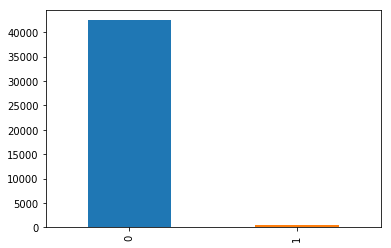

In [186]:
mailout_train['RESPONSE'].value_counts().plot(kind="bar")

As we can see bar chart above, there is a huge difference between response and no response. Our dataset is highly imbalanced.

***data_preprocessing function is modified related to response column. 
Outliers in response columns are not dropped and response column is not scaled.***

In [215]:
def data_preprocessing_2 (df, df_name = None):
    """
    data_preprocessing is modified related to response column. 
    Outliers in response columns are not dropped and response column is not scaled.
    
    Perform cleaning of demographics dataset by dropping missing columns and rows, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
    # Drop columns from customer dataset, which are not found in azdias dataset 
    if df_name=='customers':
        df_clean.drop(columns= ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Find the rows that include too many missing values and drop them if ratio of missing values more than 0.5
    df_row_nan_mean=df_clean.isnull().mean(axis=1)
    rows_to_drop=df_row_nan_mean[df_row_nan_mean>0.5].index
    df_clean.drop(rows_to_drop, inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = Imputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    
    if "RESPONSE" in df_clean.columns:
        
        # Remove outliers from dataset by using z score
        z = np.abs(stats.zscore(df_clean.drop(columns=['RESPONSE'])))
        df_clean = df_clean[(z < 6).all(axis=1)]
        df_clean.reset_index(drop=True, inplace=True)
        
        # Standardization of dataset
        lnr=df_clean['LNR']
        response=df_clean['RESPONSE']
        scaler = StandardScaler()    
        df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
        df_clean['RESPONSE']=response
        df_clean['LNR']=lnr
        
        
    else:
        # Remove outliers from dataset by using z score
        z = np.abs(stats.zscore(df_clean))
        df_clean = df_clean[(z < 6).all(axis=1)]
        df_clean.reset_index(drop=True, inplace=True)

        # Standardization of dataset
        lnr=df_clean['LNR']
        scaler = StandardScaler()
        df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
        df_clean['LNR']=lnr
   
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean

In [216]:
# preprocessing of train dataset
mailout_train_clean = data_preprocessing_2(mailout_train)

In [217]:
mailout_train.shape

(42962, 367)

In [218]:
mailout_train_clean.shape

(30506, 312)

In [219]:
# number of responses in response column in cleaned train data
mailout_train_clean["RESPONSE"].value_counts()

0.0    30126
1.0      380
Name: RESPONSE, dtype: int64

### 2.2. Modelling

In [220]:
X = mailout_train_clean.drop(columns=['RESPONSE'])
y= mailout_train_clean['RESPONSE']

In [221]:
# spliting dataset as train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

It is requested to get probabilities rather than labels. So, we will use regression models instead of classification models.

#### 2.2.1. AUC-ROC XGBRegressor model

In [266]:
# fitting XGBRegressor model with train dataset
eval_set = [(X_train, y_train), (X_test, y_test)]
clf_reg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.01)
clf_reg.fit(X_train, y_train, eval_set=eval_set,
          eval_metric="auc", verbose=True, early_stopping_rounds=100)

[0]	validation_0-auc:0.80076	validation_1-auc:0.76644
[1]	validation_0-auc:0.80082	validation_1-auc:0.76646
[2]	validation_0-auc:0.80527	validation_1-auc:0.76670
[3]	validation_0-auc:0.81083	validation_1-auc:0.76171
[4]	validation_0-auc:0.81090	validation_1-auc:0.76200
[5]	validation_0-auc:0.81129	validation_1-auc:0.76162
[6]	validation_0-auc:0.81330	validation_1-auc:0.76060
[7]	validation_0-auc:0.81228	validation_1-auc:0.76109
[8]	validation_0-auc:0.81364	validation_1-auc:0.76078
[9]	validation_0-auc:0.81489	validation_1-auc:0.75926
[10]	validation_0-auc:0.81683	validation_1-auc:0.75979
[11]	validation_0-auc:0.81654	validation_1-auc:0.76045
[12]	validation_0-auc:0.81764	validation_1-auc:0.76128
[13]	validation_0-auc:0.81900	validation_1-auc:0.76000
[14]	validation_0-auc:0.82044	validation_1-auc:0.76032
[15]	validation_0-auc:0.82050	validation_1-auc:0.76074
[16]	validation_0-auc:0.82135	validation_1-auc:0.76348
[17]	validation_0-auc:0.82146	validation_1-auc:0.76284
[18]	validation_0-au

[149]	validation_0-auc:0.94997	validation_1-auc:0.79353
[150]	validation_0-auc:0.95281	validation_1-auc:0.79734
[151]	validation_0-auc:0.95333	validation_1-auc:0.79647
[152]	validation_0-auc:0.95476	validation_1-auc:0.79887
[153]	validation_0-auc:0.95641	validation_1-auc:0.79898
[154]	validation_0-auc:0.95735	validation_1-auc:0.79844
[155]	validation_0-auc:0.95840	validation_1-auc:0.79908
[156]	validation_0-auc:0.95889	validation_1-auc:0.79911
[157]	validation_0-auc:0.95983	validation_1-auc:0.79870
[158]	validation_0-auc:0.96035	validation_1-auc:0.79930
[159]	validation_0-auc:0.96103	validation_1-auc:0.79909
[160]	validation_0-auc:0.96145	validation_1-auc:0.79824
[161]	validation_0-auc:0.96200	validation_1-auc:0.79849
[162]	validation_0-auc:0.96240	validation_1-auc:0.79791
[163]	validation_0-auc:0.96281	validation_1-auc:0.79795
[164]	validation_0-auc:0.96320	validation_1-auc:0.79780
[165]	validation_0-auc:0.96362	validation_1-auc:0.79795
[166]	validation_0-auc:0.96422	validation_1-auc:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.01, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=200, n_jobs=1, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [267]:
# roc_auc score for train data
roc_auc_score(y_train, clf_reg.predict(X_train))

0.96034761053022244

In [268]:
# roc_auc score for test data
roc_auc_score(y_test, clf_reg.predict(X_test))

0.7992981921197827

#### 2.2.2. AUC-ROC Curve

In [225]:
def plot_roc_curve(classifier, X_train, X_test, y_train, y_test):
    """
    Plot train and test roc curve for the classifier 
    
    Input: 
    X_train, X_test: Train and test dataset (DataFrame)
    y_train, y_test: Train and test labels (array)
    
    Output:
    return None
    """
    # predicted values for train and test datasets
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    
    # False positive and true positive rates calculation for predicted values
    fpr_train, tpr_train, _train = roc_curve(y_train,  y_pred_train)
    fpr_test, tpr_test, _test = roc_curve(y_test,  y_pred_test)
    
    # calculation of auc scores
    auc_train = round(roc_auc_score(y_train, y_pred_train),2)
    auc_test = round(roc_auc_score(y_test, y_pred_test),2)
      
    # plot
    plt.plot(fpr_train, tpr_train, label="Train ROC curve area = "+ str(auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC curve area = "+ str(auc_test))
    
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

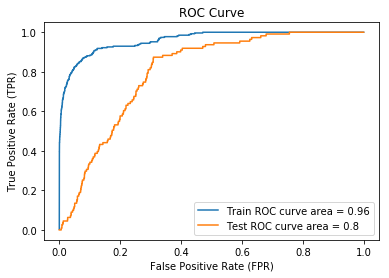

In [226]:
plot_roc_curve(clf_reg, X_train, X_test, y_train, y_test)

#### 2.2.3. Feature importance

We can see most important features by using plot_importance of xgboost. First 20 features are plotted in bar graph.

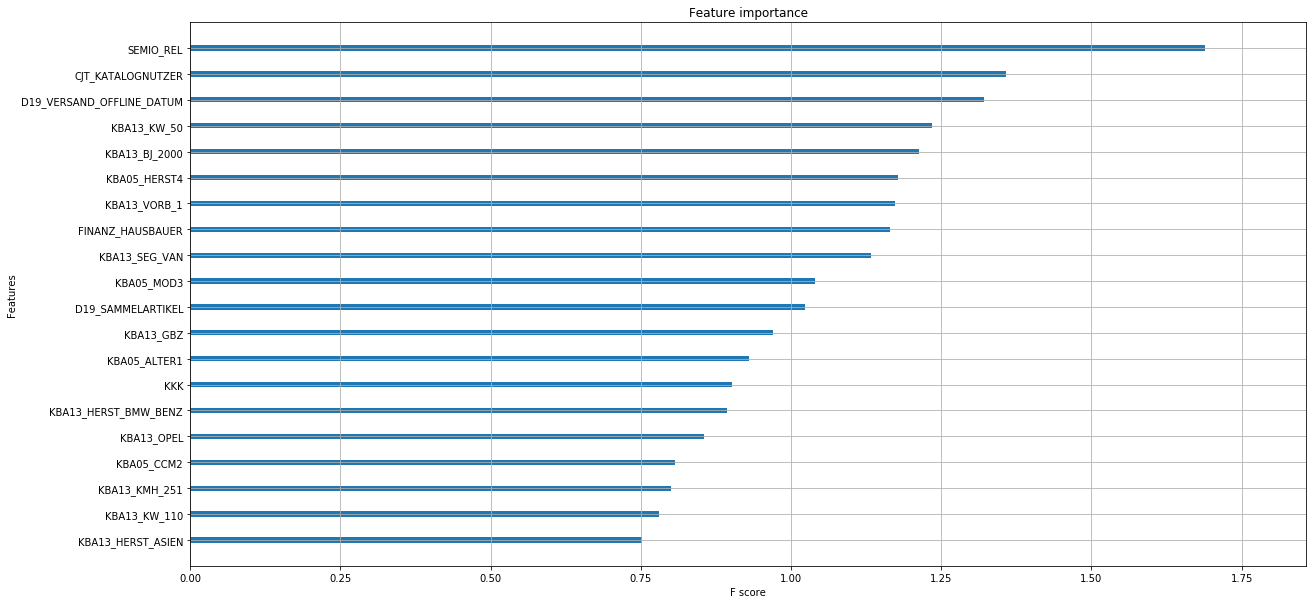

In [227]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(clf_reg, ax=ax, importance_type="gain", max_num_features=20, show_values=False, grid=True) 
#importance_type=[‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

#### 2.2.4. Fine tunning by using random search

RandomizedSearchCV from sklearn selects random combinations and mostly it finds best parameters in shorter time than grid search which is exhaustive search over specified parameters.

In [104]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [79]:
# create model with certain parameters
xgb_reg2 = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [269]:
# create random search with the model in roc auc score and wtih 4-fold cross validation
random_search = RandomizedSearchCV(xgb_reg2, params, scoring='roc_auc', cv=4)

# fitting model
random_search.fit(X, y, eval_set=eval_set, eval_metric="auc", verbose=True, early_stopping_rounds=30)

In [114]:
# best parameters for our model
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 4,
 'gamma': 2,
 'colsample_bytree': 0.8}

In [116]:
# the model got from random search with best result
rs_model=random_search.best_estimator_

In [126]:
rs_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

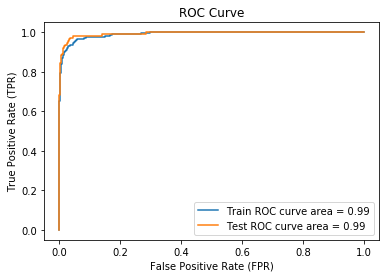

In [119]:
# roc curve for best estimator
plot_roc_curve(rs_model, X_train, X_test, y_train, y_test)

It looks pretty good. However, this result for our validation dataset. So, prediction in the final test set the important one.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [202]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [203]:
mailout_test.shape

(42833, 366)

In [204]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


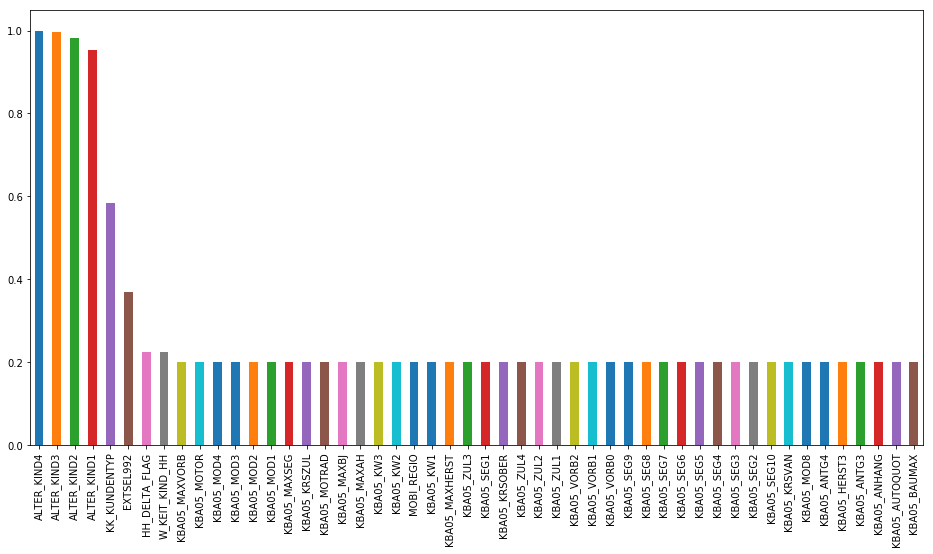

In [205]:
# null values in test dataset
mailout_test.isnull().mean().sort_values(ascending=False)[:50].plot(kind="bar", figsize=[16,8])

### 3.1. Preprocess of final test dataset

***This data prepocess function is for only final test dataset. 
We need to keep all rows for final test dataset. So, we don't drop any row.***

In [206]:
def data_preprocessing_3 (df):
    """
    ***This data prepocess function is for only final test dataset. 
    We need to keep all rows for final test dataset. So, we don't drop any row.
    
    Perform cleaning of demographics dataset by dropping missing columns only, reencoding, 
    completing missing values, and dropping correlated features
    
    Input: 
    df: Demographic dataset (DataFrame)
    df_name: Name of dataframe (str)
    
    Output:
    df_clean: Cleaned dataset (DataFrame)
    """
    # Get copy of df
    df_clean=df.copy()
    
      
    # Drop columns which involve too many missing values
    df_clean.drop(columns= ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP'], 
                  inplace=True)
    
    # Remove the columns which involve too many features
    df_clean.drop(columns=["CAMEO_DEU_2015", "CAMEO_INTL_2015", "D19_LETZTER_KAUF_BRANCHE"], inplace=True)
    
    # Change dtype of EINGEFUEGT_AM column from object to datetime and extract only year
    df_clean["EINGEFUEGT_AM"]=pd.to_datetime(df_clean["EINGEFUEGT_AM"])
    df_clean["EINGEFUEGT_AM"]=pd.DatetimeIndex(df_clean["EINGEFUEGT_AM"]).year
    
    # Convert categorical column to encoded
    df_clean["CAMEO_DEUG_2015"]=pd.factorize(df_clean["CAMEO_DEUG_2015"])[0]
    
    # Convert categorical column to encoded
    df_clean=pd.get_dummies(df_clean, drop_first=True)
        
    # Impute missing values with mode value
    imputer = Imputer(strategy='most_frequent')
    df_clean=pd.DataFrame(imputer.fit_transform(df_clean), columns = df_clean.columns)
    
    # Identify and remove 45 correlated features
    
    df_clean.drop(columns=['ANZ_STATISTISCHE_HAUSHALTE', 'CJT_TYP_2', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
    'D19_KONSUMTYP_MAX', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM',
    'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
    'KBA05_SEG2', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG9', 'KBA05_ZUL4', 'KBA13_HALTER_40', 'KBA13_HALTER_55',
    'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'KBA13_SITZE_5', 'KBA13_VW', 'LP_FAMILIE_GROB',
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'ORTSGR_KLS9', 'PLZ8_ANTG1',
    'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'VK_DISTANZ', 'VK_ZG11', 'ANREDE_KZ'], inplace=True)
    

    # Standardization of dataset
    lnr=df_clean['LNR']
    scaler = StandardScaler()
    df_clean=pd.DataFrame(scaler.fit_transform(df_clean), columns = df_clean.columns)
    df_clean['LNR']=lnr
    
    # set index LNR column
    df_clean.set_index("LNR", inplace=True)

    return df_clean

In [207]:
mailout_test_clean=data_preprocessing_3(mailout_test)

In [228]:
mailout_test_clean.shape

(42833, 311)

In [229]:
mailout_test_clean.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
1754.0,1.033789,-0.271646,-0.236176,-0.920349,-0.273330,-0.120872,-0.206929,0.108587,-0.088595,-0.211076,...,-0.052842,0.033727,1.627638,0.396115,0.659184,0.244893,-0.468790,0.178441,0.728696,0.774505
1770.0,-1.086712,-0.271646,-1.274215,-2.426369,1.047062,-0.120872,-0.206929,-0.660824,-0.088595,0.774537,...,-0.052842,0.033727,-1.245023,0.396115,0.659184,0.244893,0.579374,0.178441,0.728696,0.774505
1465.0,1.033789,4.719141,1.098445,0.334667,-0.273330,-0.120872,-0.206929,1.647408,-0.088595,0.774537,...,-0.052842,0.033727,0.670084,1.668202,-1.591635,0.244893,0.055292,0.178441,0.728696,0.774505
1470.0,-1.086712,3.471445,-1.274215,-2.426369,-0.346685,-0.120872,-0.206929,-1.430235,-0.088595,0.774537,...,0.909884,0.033727,-0.287470,0.714136,0.659184,0.244893,-0.992871,0.178441,0.728696,-1.291147
1478.0,0.326956,-0.271646,1.839902,0.836674,-0.346685,-0.120872,-0.206929,1.647408,-0.088595,-0.211076,...,-0.052842,0.033727,-1.245023,-0.557951,-1.028930,0.244893,1.627537,1.070811,0.728696,0.774505


In [231]:
# prediction by using previous model
y_test_pred=rs_model.predict(mailout_test_clean)

In [232]:
y_test_pred

array([ 0.12584868,  0.13262419,  0.10235318, ...,  0.10826494,
        0.12451632,  0.12213261], dtype=float32)

In [233]:
y_test_pred.shape

(42833,)

In [234]:
# create dataframe by using LNR column and predictions
df_kaggle=pd.DataFrame({"RESPONSE": y_test_pred},index= mailout_test_clean.index.astype(int))

In [235]:
df_kaggle.shape

(42833, 1)

In [236]:
df_kaggle.head()

,RESPONSE
LNR,
1754,0.125849
1770,0.132624
1465,0.102353
1470,0.102383
1478,0.108291


In [237]:
df_kaggle.to_csv('kaggle_submission.csv')